# Importing the libraries

In [9]:
%pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 13.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input,Session

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Creating the variables of backut name and region of aws

In [2]:
bucket_name = 'aws-crop'
my_region = boto3.session.Session().region_name
print(my_region)

us-east-1


# Figuring out if the s3 bucket is in the us-east or not

In [3]:
s3=boto3.resource('s3')
try:
    if my_region=='us-east-1':
        s3.create_bucket(Bucket= bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error:',e)

S3 bucket created successfully


# Generating the S3 path for storing output data with a given prefix

In [4]:
prefix= 'xgboost-as-a-built-in-algo'
output_path = 's3://{}/{}/output'.format(bucket_name,prefix)
print(output_path)

s3://aws-crop/xgboost-as-a-built-in-algo/output


# Importing the dataset using the pandas library

In [28]:
import pandas as pd
sheet_stats = ['CropStats']
df = pd.concat(pd.read_excel('./crops.xlsx', sheet_name=sheet_stats))
print('Success: Data loaded into dataframe.')

Success: Data loaded into dataframe.


# Preprocessing data

In [12]:
df

Unnamed: 0  Harvest_year   admin0    admin1   crop  \
CropStats 0               0          1902  Austria       NaN  wheat   
          1               1          1903  Austria       NaN  wheat   
          2               2          1904  Austria       NaN  wheat   
          3               3          1905  Austria       NaN  wheat   
          4               4          1906  Austria       NaN  wheat   
...                     ...           ...      ...       ...    ...   
          36702       36702          2013    China  zhejiang  wheat   
          36703       36703          2014    China  zhejiang  wheat   
          36704       36704          2015    China  zhejiang  wheat   
          36705       36705          2016    China  zhejiang  wheat   
          36706       36706          2017    China  zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  \
CropStats 0                NaN                  NaN  1902          1.310000   
          1                NaN                  NaN  1903          1.470000   
          2                NaN                  NaN  1904          1.270000   
          3                NaN                  NaN  1905          1.330000   
          4                NaN                  NaN  1906          1.280000   
...                        ...                  ...   ...               ...   
          36702        75520.0             278300.0  2013          3.685117   
          36703        82120.0             309500.0  2014          3.768875   
          36704        89800.0             351300.0  2015          3.912027   
          36705        76590.0             253900.0  2016          3.315054   
          36706       103670.0             419200.0  2017          4.043600   

                 admin2 notes  
CropStats 0         NaN   NaN  
          1         NaN   NaN  
          2         NaN   NaN  
          3         NaN   NaN  
          4         NaN   NaN  
...                 ...   ...  
          36702     NaN   NaN  
          36703     NaN   NaN  
          36704     NaN   NaN  
          36705     NaN   NaN  
          36706     NaN   NaN  

[36707 rows x 11 columns]

In [29]:
# Removing the notes column because it is of no use for our model.
notes_values = df['notes'].dropna().tolist()
# Drop the columns notes and admin2 (not useful)
df = df.drop(columns=['notes', 'admin2'])
# Rename 'admin0' to 'Country' and 'admin1' to 'City'
df = df.rename(columns={'admin0': 'Country', 'admin1': 'City'})
df["City"].fillna("Not defined", inplace=True)
# Fill the null values of hectares, production and yield with 0 to not miss any upon calculation
df.fillna(0, inplace=True)

df = df[df['Country'] == 'United States']
df = df[~((df['production (tonnes)'] == 0) & ((df['yield(tonnes/ha)'] == 0) | (df['hectares (ha)'] == 0)))]
# Find the indexes of rows where 'production' is zero
zero_indexes = df[df['production (tonnes)'] == 0].index
# Loop through the zero valued indexes and calculate the missing 'production' values
for index in zero_indexes:
    df.at[index, 'production (tonnes)'] = df.at[index, 'yield(tonnes/ha)'] * df.at[index, 'hectares (ha)']
# Some might argue that we should keep the row if the production has a value but yield doesn't, but in our case we need rows without zeros for a good prediction
df = df[~((df['yield(tonnes/ha)'] == 0) & ((df['production (tonnes)'] == 0) | (df['hectares (ha)'] == 0)))]
# Some might argue that we should keep the row if the production has a value but hectares doesn't, but in our case we need rows without zeros for a good prediction
df = df[~((df['hectares (ha)'] == 0) & ((df['production (tonnes)'] == 0) | (df['yield(tonnes/ha)'] == 0)))]
# Find the indexes of rows where 'hectares' is zero
zero_indexes = df[df['hectares (ha)'] == 0].index
# Loop through the zero valued indexes and calculate the missing 'hectares' values
for index in zero_indexes:
    df.at[index, 'hectares (ha)'] = df.at[index, 'production (tonnes)'] / df.at[index, 'yield(tonnes/ha)']
# Select specific columns and reorder them
df = df[['year', 'Harvest_year', 'crop', 'hectares (ha)', 'yield(tonnes/ha)', 'production (tonnes)']]
df = pd.get_dummies(df, columns=['crop'])
cols_to_drop = ['Harvest_year']
df.drop(columns=cols_to_drop, axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
 
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['yield(tonnes/ha)', 'production (tonnes)', 'hectares (ha)', 'year']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

Q1 = df['production (tonnes)'].quantile(0.25)
Q3 = df['production (tonnes)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
 
# Remove outliers
df = df[(df['production (tonnes)'] >= lower_bound) & (df['production (tonnes)'] <= upper_bound)]
 
# # Define your X (features) and Y (target)
# X = df.drop(['production (tonnes)','City','Country'], axis=1)
# y = df['production (tonnes)']

# df

# Splitting the data into training and testing data using a random state

In [30]:
import numpy as np
train_data,test_data = np.split(df.sample(frac=1,random_state=1729),[int(0.7*len(df))])
print(train_data.shape,test_data.shape)

(11153, 8) (4781, 8)


In [15]:
train_data

year  hectares (ha)  yield(tonnes/ha)  \
CropStats 23640 -1.461635       0.538940         -0.789922   
          14253  0.148180      -0.616324         -0.318170   
          22613 -0.909012      -0.615393         -0.518300   
          24942 -0.308335      -0.033107         -1.016616   
          13256  0.724831       3.848337         -0.370248   
...                   ...            ...               ...   
          18018  1.565779      -0.541851          4.542444   
          21549 -0.380416       0.566867         -0.961473   
          18289  1.421617      -0.210446          2.626795   
          19210  0.868993      -0.582811          2.398061   
          22146 -0.692768      -0.546040         -0.203791   

                 production (tonnes)  crop_maize  crop_spring wheat  \
CropStats 23640            -0.145622           1                  0   
          14253            -0.345586           0                  0   
          22613            -0.345646           1                  0   
          24942            -0.304932           0                  1   
          13256             1.272148           0                  0   
...                              ...         ...                ...   
          18018            -0.145712           1                  0   
          21549            -0.232438           1                  0   
          18289             0.354214           1                  0   
          19210            -0.287109           1                  0   
          22146            -0.314634           1                  0   

                 crop_wheat  crop_winter wheat  
CropStats 23640           0                  0  
          14253           1                  0  
          22613           0                  0  
          24942           0                  0  
          13256           1                  0  
...                     ...                ...  
          18018           0                  0  
          21549           0                  0  
          18289           0                  0  
          19210           0                  0  
          22146           0                  0  

[12483 rows x 8 columns]

# Creating the training data set as csv and uploading it to S3

In [31]:
import os
from sagemaker.inputs import TrainingInput
file_name = 'crop_train.csv'
pd.concat([train_data],axis=1).to_csv(file_name,index=False,header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix,'train/crop_train.csv')).upload_file(file_name)
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


# Creating the test data set as csv and uploading it to S3

In [32]:
file_name_test = 'crop_test.csv'
pd.concat([test_data],axis=1).to_csv(file_name_test,index=False,header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix,'test/crop_test.csv')).upload_file(file_name_test)
s3_input_test = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


# Container helps to hold uri for the xgboost container image. It helps to used for the sagemaker tasks like training model.

In [33]:
import sagemaker
container = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=boto3.Session().region_name,
    version="1.0-1"
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


# Hyperparameters helps to control the XGBoost algorithm behavior

In [34]:
hyperparameters = {
    "objective": "reg:linear",
    "num_round": 100,
    "max_depth": 5,
    "eta": 0.1,
    "gamma": 0.1,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

# Setup of the sagemaker estimator to configure the training model 

In [35]:
estimator = sagemaker.estimator.Estimator(
    image_uri=container,
    hyperparameters=hyperparameters,
    role=sagemaker.get_execution_role(),
    instance_count=1,  # Update this line
    instance_type='ml.m4.xlarge',  # Update this line
    volume_size=5,  # Update this line
    output_path=output_path,
    use_spot_instances=True,  # Update this line
    max_run=300,  # Update this line
    max_wait=600,# Update this line
      # Add TrainingImageConfig to specify your private Docker registry
    training_image_config={
        "RepositoryAccessMode": "Vpc",  # Specify Vpc if it's a private Docker registry
        # Add any other required configurations for your private registry
    },
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [36]:
estimator.fit({'train':s3_input_train,'validation':s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-06-01-16-54-285


2023-11-06 01:16:54 Starting - Starting the training job...
2023-11-06 01:17:19 Starting - Preparing the instances for training............
2023-11-06 01:18:57 Downloading - Downloading input data...
2023-11-06 01:19:27 Training - Downloading the training image...
2023-11-06 01:20:13 Training - Training image download completed. Training in progress...[2023-11-06 01:20:30.016 ip-10-2-140-176.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined d

# xgb predictor helps to send input data for inference and receive prediction from the deployment in xgboost model.

In [37]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-06-01-21-32-833
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-06-01-21-32-833
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-06-01-21-32-833


------!

# Making prediction that deploys in xgboost model and prints out the shape of the prediction array

In [38]:
test_data.columns

Index(['year', 'hectares (ha)', 'yield(tonnes/ha)', 'production (tonnes)',
       'crop_maize', 'crop_spring wheat', 'crop_wheat', 'crop_winter wheat'],
      dtype='object')

In [39]:
from sagemaker.serializers import CSVSerializer
test_data_array = test_data.drop(columns=['production (tonnes)'],axis=1).values

xgb_predictor.serializer = CSVSerializer()

predictions = xgb_predictor.predict(test_data_array).decode('utf-8')

predictions_array = np.fromstring(predictions[1:],sep=',')
print(predictions_array.shape)

(4781,)


In [40]:
print(np.min(predictions_array))
print(np.max(predictions_array))


-1.3628668785095215
1.338490605354309


In [41]:
X_test = test_data.drop(columns=['production (tonnes)']) 
y_true = test_data['production (tonnes)'].values
# Make predictionspredictions = xgb_predict(X_test) # Calculate RMSErmse = np.sqrt(((y_true - predictions) ** 2).mean())print(f'RMSE: {rmse}')

# Plotting the results

(4781,)


/tmp/ipykernel_11429/491232514.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([test_data_production.min(), test_data_production.max()], [test_data_production.min(), test_data_production.max()], 'k--', c='red', lw=3, label='Perfect Prediction')


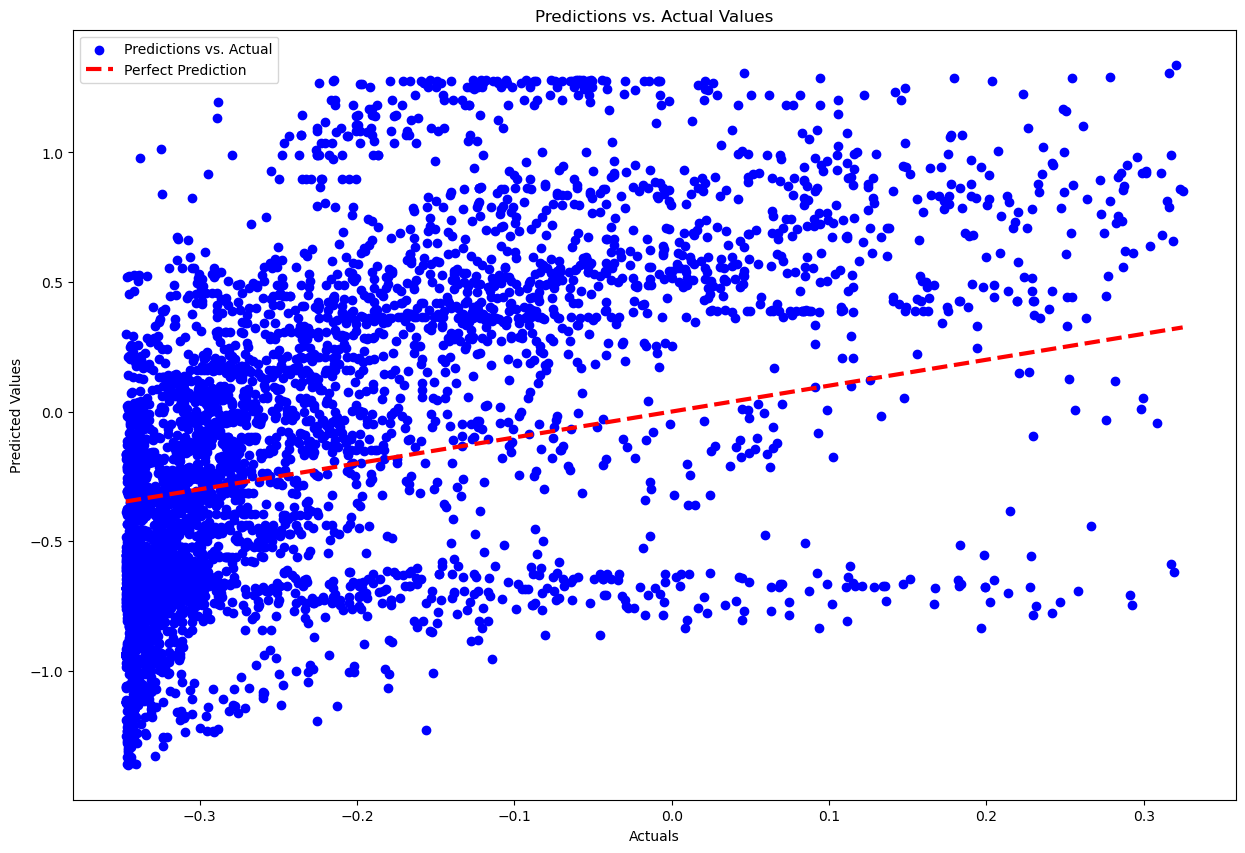

In [42]:
import matplotlib.pyplot as plt
test_data_production = test_data['production (tonnes)'].values
print(test_data_production.shape)
plt.figure(figsize=(15,10))
plt.scatter(test_data_production, predictions_array, c='b', label='Predictions vs. Actual')
plt.plot([test_data_production.min(), test_data_production.max()], [test_data_production.min(), test_data_production.max()], 'k--', c='red', lw=3, label='Perfect Prediction')
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predictions vs. Actual Values')
plt.show()

In [207]:
print(np.max(predictions_array))

1.4929375648498535


# We tried our best to get good prediction but we didn't manage

# Clean up the resources after deploying the amazon sagemaker

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
buckte_to_delete=boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()